In [ ]:
!wget https://he-s3.s3.amazonaws.com/media/hackathon/amazon-ml-engineer-hiring-challenge/amazon-ml-2020-predict-the-category-of-the-customer-5-c575cc6b/9e5938fc2ce611eb.zip

--2020-12-06 14:26:01--  https://he-s3.s3.amazonaws.com/media/hackathon/amazon-ml-engineer-hiring-challenge/amazon-ml-2020-predict-the-category-of-the-customer-5-c575cc6b/9e5938fc2ce611eb.zip
Resolving he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)... 52.219.40.20
Connecting to he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)|52.219.40.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1373655 (1.3M) [application/zip]
Saving to: ‘9e5938fc2ce611eb.zip’

9e5938fc2ce611eb.zi 100%[===================>]   1.31M  1.31MB/s    in 1.0s    

2020-12-06 14:26:03 (1.31 MB/s) - ‘9e5938fc2ce611eb.zip’ saved [1373655/1373655]



In [ ]:
!unzip 9e5938fc2ce611eb.zip

Archive:  9e5938fc2ce611eb.zip
  inflating: train.csv               
  inflating: test.csv                


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install catboost

     |████████████████████████████████| 66.3MB 60kB/s 


In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
re=test['customer_id']

In [ ]:
train.head(5)

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1,customer_category
0,csid_1,13.168425,9.447662,-0.070203,-0.139541,0.436956,4.705761,2.537985,7.959503,C,F,0
1,csid_2,17.092979,7.329056,0.153298,-0.102726,0.380340,4.205138,4.193444,17.517381,C,A,0
2,csid_3,17.505334,5.143676,0.106709,0.262834,0.417648,4.479070,3.878971,12.595155,C,BA,0
3,csid_4,31.423381,4.917740,-0.020226,-0.100526,0.778130,5.055535,2.708940,4.795073,AA,F,0
4,csid_5,11.909502,4.237073,0.187178,0.172891,0.162067,3.445247,3.677360,56.636326,C,AA,0


In [ ]:
test.head(5)

,customer_id,customer_visit_score,customer_product_search_score,customer_ctr_score,customer_stay_score,customer_frequency_score,customer_product_variation_score,customer_order_score,customer_affinity_score,customer_active_segment,X1
0,csid_10739,22.500174,3.702145,0.118811,0.093253,0.689237,5.786842,3.748009,7.661716,B,BA
1,csid_10740,13.225950,3.600102,0.130985,0.053575,0.142756,3.940359,3.469659,33.999679,B,AA
2,csid_10741,14.603376,5.084047,-0.004651,-0.036299,0.333709,4.254662,3.855939,33.485630,B,AA
3,csid_10742,26.149905,3.025501,0.229740,0.204591,3.768405,6.942625,2.362421,0.795372,B,BA
4,csid_10743,19.810630,5.020400,-0.011347,-0.028780,0.286841,4.585513,3.278624,15.052058,C,BA


In [ ]:
df=pd.concat([train,test])

In [ ]:
df.nunique(), df.isnull().sum(),df.dtypes

(customer_id                         17898
 customer_visit_score                17898
 customer_product_search_score       17827
 customer_ctr_score                  17898
 customer_stay_score                 17845
 customer_frequency_score            17898
 customer_product_variation_score    17809
 customer_order_score                17791
 customer_affinity_score             17898
 customer_active_segment                 5
 X1                                      5
 customer_category                       2
 dtype: int64, customer_id                            0
 customer_visit_score                   0
 customer_product_search_score         71
 customer_ctr_score                     0
 customer_stay_score                   53
 customer_frequency_score               0
 customer_product_variation_score      89
 customer_order_score                 107
 customer_affinity_score                0
 customer_active_segment               35
 X1                                    62
 custome

In [ ]:
df['customer_product_search_score']=df['customer_product_search_score'].fillna(df['customer_product_search_score'].mean())
df['customer_stay_score']=df['customer_stay_score'].fillna(df['customer_stay_score'].mean())
df['customer_product_variation_score']=df['customer_product_variation_score'].fillna(df['customer_product_variation_score'].mean())
df['customer_order_score']=df['customer_order_score'].fillna(df['customer_order_score'].mean())
df['customer_active_segment']=df['customer_active_segment'].fillna(method='bfill')
df['X1']=df['X1'].fillna(method='bfill')

In [ ]:
df['extraa_score']=df['customer_ctr_score']*(df['customer_product_search_score']+df['customer_product_variation_score'])

In [ ]:
x=['customer_id']
for i in x:
  from sklearn.preprocessing import LabelEncoder
  le = LabelEncoder()
  df[i] = le.fit_transform(df[i])

In [ ]:
df = pd.get_dummies(df, columns=['customer_active_segment','X1'])

In [ ]:
#del df['customer_id']

In [ ]:
train = df[df['customer_category'].isnull()==False]
test = df[df['customer_category'].isnull()==True]
del test['customer_category']

In [ ]:
train_df=train.copy()
test_df=test.copy()

# F2

In [ ]:
from math import sqrt 
from sklearn.metrics import f1_score

In [ ]:
X = train_df.drop(labels=['customer_category'], axis=1)
y = train_df['customer_category'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.10, random_state=101)

In [ ]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((9664, 21), (9664,), (1074, 21), (1074,))

In [ ]:
categorical_features_indices = np.where(X_train.dtypes == 'category')[0]
categorical_features_indices

array([], dtype=int64)

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         classes_count=2,
                         depth=10,
                         random_seed=101, 
                         iterations=3500, 
                         learning_rate=0.1,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         border_count=100,
                         od_wait=500)
cat.fit(X_train, y_train, verbose=100,
        use_best_model=True,
        cat_features=categorical_features_indices,
        eval_set=[(X_train, y_train),(X_cv, y_cv)],
        plot=False)
predictions = cat.predict(X_cv)
print('accuracy:', f1_score(y_cv, predictions, average='macro'))

0:	learn: 0.9742542	test: 0.9742542	test1: 0.9746347	best: 0.9746347 (0)	total: 40.3ms	remaining: 2m 20s
100:	learn: 0.9873923	test: 0.9873923	test1: 0.9811067	best: 0.9811067 (86)	total: 3.46s	remaining: 1m 56s
200:	learn: 0.9944777	test: 0.9944777	test1: 0.9820847	best: 0.9820847 (149)	total: 6.9s	remaining: 1m 53s
300:	learn: 0.9990672	test: 0.9990672	test1: 0.9811067	best: 0.9820847 (149)	total: 10.3s	remaining: 1m 49s
400:	learn: 1.0000000	test: 1.0000000	test1: 0.9801988	best: 0.9820847 (149)	total: 13.7s	remaining: 1m 45s
500:	learn: 1.0000000	test: 1.0000000	test1: 0.9801988	best: 0.9820847 (149)	total: 17.1s	remaining: 1m 42s
600:	learn: 1.0000000	test: 1.0000000	test1: 0.9801988	best: 0.9820847 (149)	total: 20.5s	remaining: 1m 38s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.9820846722
bestIteration = 149

Shrink model to first 150 iterations.
accuracy: 0.9555992662977847


In [ ]:
print('accuracy:', f1_score(y_cv, predictions, average='macro'))

accuracy: 0.9555992662977847


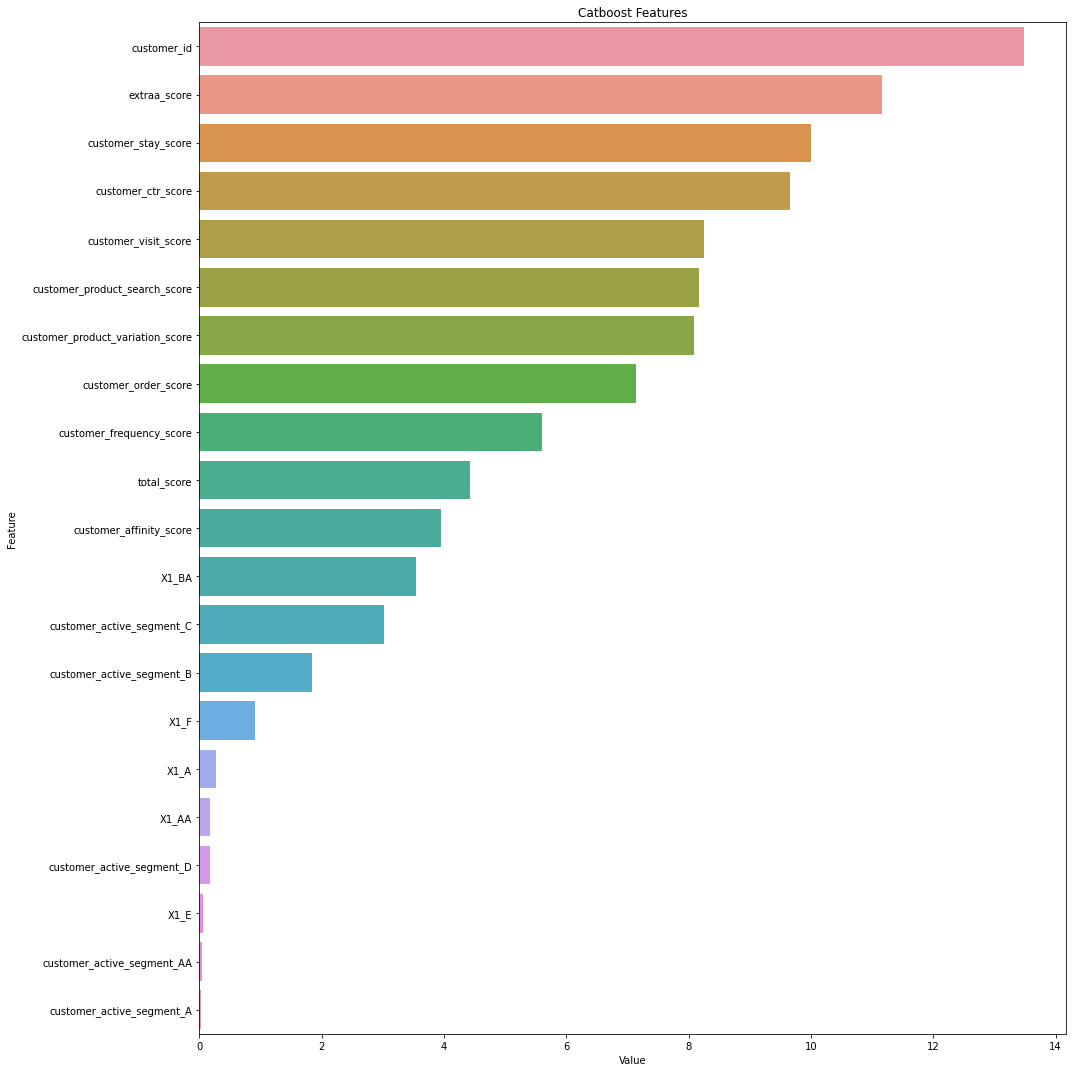

In [ ]:
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(cat.feature_importances_, X.columns), reverse=True)[:50], 
                           columns=['Value','Feature'])
plt.figure(figsize=(15,15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Catboost Features')
plt.tight_layout()
plt.show()

In [ ]:
Xtest = test_df

In [ ]:
from sklearn.model_selection import KFold

errcat = []
y_pred_totcat = []

fold = KFold(n_splits=10, shuffle=True, random_state=101)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='TotalF1', 
                         classes_count=2,
                         depth=10,
                         random_seed=101, 
                         iterations=3500, 
                         learning_rate=0.1,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=0.9, 
                         random_strength=1,
                         od_type='Iter', 
                         border_count=100,
                         od_wait=500)
    cat.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=200, cat_features=categorical_features_indices)

    y_pred_cat = cat.predict(X_test)
    print("Accuracy: ", f1_score(y_test,y_pred_cat, average='macro'))

    errcat.append(f1_score(y_test,y_pred_cat, average='macro'))
    p = cat.predict(Xtest)
    y_pred_totcat.append(p)

Accuracy:  0.9530922431865829
Accuracy:  0.9637850368809273
Accuracy:  0.9431144067796611
Accuracy:  0.9234373481092641
Accuracy:  0.9490681462512449
Accuracy:  0.9502044257112751
Accuracy:  0.9466381517125173
Accuracy:  0.9568133564948852
Accuracy:  0.927548164363272
Accuracy:  0.9508085622083624


In [ ]:
np.mean(errcat,0)

0.9464509841697991

In [ ]:
cat_final = np.mean(y_pred_totcat,0).round().astype(int)
cat_final

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [ ]:
xxx = pd.DataFrame(data=cat_final, columns=['customer_category'])

In [ ]:
submission = pd.DataFrame({
        "customer_id":re,
        "customer_category": xxx['customer_category'],
    })
submission.to_csv('./submission.csv', index=False)
print(submission)

     customer_id  customer_category
0     csid_10739                  0
1     csid_10740                  0
2     csid_10741                  0
3     csid_10742                  0
4     csid_10743                  0
...          ...                ...
7155  csid_17894                  0
7156  csid_17895                  0
7157  csid_17896                  0
7158  csid_17897                  0
7159  csid_17898                  1

[7160 rows x 2 columns]


In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# f4

In [ ]:
train_df=train.copy()
test_df=test.copy()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install rfpimp
!pip install catboost
from sklearn.metrics import mean_absolute_error,accuracy_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold,KFold,GridSearchCV,GroupKFold,train_test_split,StratifiedShuffleSplit
from rfpimp import *
from tqdm import tqdm
from catboost import *
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

  Created wheel for rfpimp: filename=rfpimp-1.3.6-cp36-none-any.whl size=10646 sha256=e67042490830b13320e0f8d912f3ca7c07e0e00c0c696f913115b2dc65b53b99
  Stored in directory: /root/.cache/pip/wheels/4d/dc/d3/cf941c8f72eb5f1864506a1a6ddd689729063798292e539522
Successfully built rfpimp


In [ ]:
df_train = train_df
df_test = test_df

In [ ]:
X_train = train_df.drop(['customer_category'],axis=1)
y_train = train_df['customer_category']

In [ ]:
x=[]
for i in test_df.columns:
  x.append(i)
x=np.array(x)
x

array(['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score',
       'customer_frequency_score', 'customer_product_variation_score',
       'customer_order_score', 'customer_affinity_score', 'extraa_score',
       'customer_active_segment_A', 'customer_active_segment_AA',
       'customer_active_segment_B', 'customer_active_segment_C',
       'customer_active_segment_D', 'X1_A', 'X1_AA', 'X1_BA', 'X1_E',
       'X1_F'], dtype='<U32')

In [ ]:
feats=['customer_visit_score', 'customer_product_search_score',
       'customer_ctr_score', 'customer_stay_score',
       'customer_frequency_score', 'customer_product_variation_score',
       'customer_order_score', 'customer_affinity_score', 'extraa_score',
       'customer_active_segment_A', 'customer_active_segment_AA',
       'customer_active_segment_B', 'customer_active_segment_C',
       'customer_active_segment_D', 'X1_A', 'X1_AA', 'X1_BA', 'X1_E',
       'X1_F']

In [ ]:
splits = 15
folds =StratifiedKFold(n_splits=splits, random_state=42,shuffle=True)
oof_preds = np.zeros((len(df_test), 2))
feature_importance_df = pd.DataFrame()
feature_importance_df['Feature'] = X_train.columns
final_preds = []
random_state = [22,44,66,77,88,99,101]
counter = 0

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values,y_train)):
        print("iter_ {}".format(fold_))
        X_trn,y_trn = X_train[feats].iloc[trn_idx],y_train.iloc[trn_idx]
        X_val,y_val = X_train[feats].iloc[val_idx],y_train.iloc[val_idx]
        clf = lgb.LGBMClassifier(boosting='gbdt',learning_rate=0.1, n_estimators=1000, random_state=101, subsample=0.9,max_depth=-1,num_leaves=31)#
         #,
         #min_data_in_leaf=11,
         #bagging_fraction=0.90,
         #bagging_freq=2,
         #bagging_seed=3,
         #feature_fraction=0.90,
         #feature_fraction_seed=2,
         #early_stopping_round=200,
         #max_bin=1000)#(n_estimators=1000,max_depth=4,random_state=42)#dart
        clf.fit(X_trn, y_trn,eval_set=[(X_trn, y_trn), (X_val, y_val)],verbose=0,
                eval_metric='multi_error',early_stopping_rounds=100)
        
        imp = importances(clf,X_val,y_val)
        imp.rename(columns={'Importance':f'Importance_{fold_}'},inplace=True)
        feature_importance_df = pd.merge(feature_importance_df,imp,on='Feature')
        final_preds.append(accuracy_score(y_pred=clf.predict(X_val),y_true=y_val))
        
        oof_preds += clf.predict_proba(df_test[feats])
oof_preds = oof_preds/splits
print(sum(final_preds)/splits)

iter_ 0
iter_ 1
iter_ 2
iter_ 3
iter_ 4
iter_ 5
iter_ 6
iter_ 7
iter_ 8
iter_ 9
iter_ 10
iter_ 11
iter_ 12
iter_ 13
iter_ 14
0.9769979554895756


In [ ]:
preds_x = [np.argmax(x) for x in oof_preds]

In [ ]:
submission = pd.DataFrame({
        "customer_id":re,
        "customer_category": preds_x
    })
submission.to_csv('./submission.csv', index=False)
print(submission)

     customer_id  customer_category
0     csid_10739                  0
1     csid_10740                  0
2     csid_10741                  0
3     csid_10742                  0
4     csid_10743                  0
...          ...                ...
7155  csid_17894                  0
7156  csid_17895                  0
7157  csid_17896                  0
7158  csid_17897                  0
7159  csid_17898                  1

[7160 rows x 2 columns]


In [ ]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>